In [55]:
import os
import matplotlib.pyplot as plt
import CGRtools
import multiprocessing
import networkx as nx

from tqdm import tqdm
from rdkit import Chem

import sys
sys.path.append("../")
from autotemplate.extract_utils import extract_from_rxn_smiles

def give_mapnum_for_unmapped_reactant_atoms(rxn_smiles):
    """ 
    Leaving group atoms in reactnat site have no atom mapping number.
    Try to append atom mapping number for those reactant atoms.
    """
    reac, prod = rxn_smiles.split('>>')
    reac = Chem.MolFromSmiles(reac)
    prod = Chem.MolFromSmiles(prod)
    if reac.GetNumAtoms() > prod.GetNumAtoms():
        reac_map = {i+1 for i in range(reac.GetNumAtoms())}
        prod_map = {int(atom.GetProp('molAtomMapNumber')) for atom in prod.GetAtoms()}
        undetermined_map = reac_map.difference(prod_map)
        for atom in reac.GetAtoms():
            if not atom.HasProp('molAtomMapNumber'):
                num = undetermined_map.pop()
                atom.SetAtomMapNum(num)
                if not undetermined_map: break
        return Chem.MolToSmiles(reac) + '>>' + Chem.MolToSmiles(prod)
    else:
        return rxn_smiles

def subprocess(line):
    rxn_smiles, id_ = line.strip().split("\t")
    rxn_smiles = give_mapnum_for_unmapped_reactant_atoms(rxn_smiles)
    template = extract_from_rxn_smiles(rxn_smiles)
    product, reactant = template.split(">>")
    return id_, reactant

def lines2data_dict(data_lines, ncpus=48):
    id2reactant = dict()
    with multiprocessing.Pool(processes=ncpus) as pool:
        results = pool.map(subprocess, data_lines)
    # for line in data_lines:
    #     rxn_smiles, id_ = line.strip().split("\t")
    #     rxn_smiles = give_mapnum_for_unmapped_reactant_atoms(rxn_smiles)
    #     template = extract_from_rxn_smiles(rxn_smiles)
    #     product, reactant = template.split(">>")
        # reactant, product = rxn_smiles.split(">>")
    for id_, reactant in results:
        id2reactant.update({id_: reactant})
    return id2reactant

def cgr_representation(rxn_smiles):
    r = CGRtools.smiles(rxn_smiles)
    r.clean2d()
    cgr = ~r
    return cgr.__str__()

def mp_wrapper_cgr(lines, ncpus=48):
    rxn_smiles_list, reaction_id_list = list(zip(*[line.strip().split("\t") for line in lines]))
    with multiprocessing.Pool(processes=ncpus) as pool:
        cgr_list = pool.map(cgr_representation, rxn_smiles_list)
    return {reaction_id: cgr for reaction_id, cgr in zip(reaction_id_list, cgr_list)}

def get_atoms_attributes(rdkit_molecule):
    attributes = []
    for a in rdkit_molecule.GetAtoms():
        attributes.append((a.GetAtomMapNum(), {'Symbol':a.GetSymbol(), 'Charge':a.GetFormalCharge()}))
    return attributes

def get_bonds_attributes(rdkit_molecule):
    attributes = []
    for b in rdkit_molecule.GetBonds():
        start = b.GetBeginAtom().GetAtomMapNum()
        end = b.GetEndAtom().GetAtomMapNum()
        b_type = b.GetBondTypeAsDouble()
        attributes.append((start, end, b_type))
    return attributes

def topology_from_rdkit(rdkit_molecule):
    topology = nx.Graph()
    topology.add_nodes_from(get_atoms_attributes(rdkit_molecule))
    topology.add_weighted_edges_from(get_bonds_attributes(rdkit_molecule))
    return topology

def difference_only_halogen(smiles_1, smiles_2):
    G1 = topology_from_rdkit(Chem.MolFromSmarts(smiles_1))
    G2 = topology_from_rdkit(Chem.MolFromSmarts(smiles_2))
    ismags = nx.isomorphism.ISMAGS(G1,G2, node_match=lambda n1,n2:n1['Symbol']==n2['Symbol'],
                                    edge_match=lambda e1,e2:e1['weight']==e2['weight'])
    largest_common_subgraph_mapping = list(ismags.largest_common_subgraph(symmetry=False))[0]
    different_nodes_G1 = set(G1.nodes) - set(largest_common_subgraph_mapping.keys())
    different_nodes_G2 = set(G2.nodes) - set(largest_common_subgraph_mapping.values())
    for map_num in different_nodes_G1:
        if G1.nodes[map_num]["Symbol"] not in ["F", "Cl", "Br", "I"]:
            return False
    for map_num in different_nodes_G2:
        if G2.nodes[map_num]["Symbol"] not in ["F", "Cl", "Br", "I"]:
            return False
    return True

fractions = [3, 5, 10, 15, 20]
thresholds = [1, 3, 5]

In [49]:
golden_data_path = "../data_USPTO_50k_coley/USPTO_50k_coley.txt"
with open(golden_data_path, "r") as f:
    golden_lines = f.readlines()
golden_id2cgr_dict = mp_wrapper_cgr(golden_lines)
num_total_data = len(golden_id2cgr_dict)
golden_id2reactant_dict = lines2data_dict(golden_lines)

In [26]:
threshold_performance = {1:[], 3:[], 5:[]}
for threshold in thresholds:
    for fraction in tqdm(fractions):
        data_path = f"../data_USPTO_50k_noise/USPTO_50k_{fraction}perc_noise/threshold_{threshold}/USPTO_50k_{fraction}perc_noise.txt.processed"
        with open(data_path, "r") as f:
            prcessed_lines = f.readlines()
        prcessed_id2cgr_dict = mp_wrapper_cgr(prcessed_lines)
    
        num_cgr_false = 0
        for reaction_id in prcessed_id2cgr_dict.keys():
            if prcessed_id2cgr_dict[reaction_id] != golden_id2cgr_dict[reaction_id]:
                # print(reaction_id, prcessed_id2cgr_dict[reaction_id], golden_id2cgr_dict[reaction_id])
                num_cgr_false += 1
        num_correct = len(prcessed_id2cgr_dict) - num_cgr_false
        residual_proportion = num_correct / num_total_data
        threshold_performance[threshold].append(residual_proportion)

100%|██████████| 5/5 [01:14<00:00, 15.00s/it]


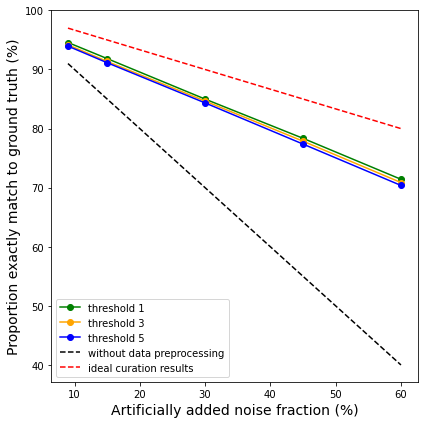

In [27]:
fractions = [3, 5, 10, 15, 20]

fig, ax = plt.subplots(figsize=(6,6))
noise_fractions = [x*3 for x in fractions]
noise_residual = [100 - x for x in noise_fractions]
ideal_residual = [100 - x/3 for x in noise_fractions]
color_dict = {1: "green", 3: "orange", 5: "blue"}

for threshold in thresholds:
    performance = threshold_performance[threshold]
    performance = [100*x for x in performance]
    ax.plot(noise_fractions, performance, color=color_dict[threshold], marker="o", label="threshold "+str(threshold))

ax.plot(noise_fractions, noise_residual, color="black", linestyle='dashed', label="without data preprocessing")
ax.plot(noise_fractions, ideal_residual, color="red", linestyle='dashed', label="ideal curation results")
ax.set_xlabel("Artificially added noise fraction (%)", fontsize=14)
ax.set_ylabel('Proportion exactly match to ground truth (%)', fontsize=14)
ax.set_yticks([40, 50, 60, 70, 80, 90, 100])
ax.set_xticks([10, 20, 30, 40, 50, 60])

ax.legend()
plt.tight_layout()
plt.savefig("../docs/noise_experiments.svg", format="svg")
plt.show()


In [57]:
def error_type2id_dict(trace_path):
    with open(trace_path, "r") as f:
        trace_lines = f.readlines()
    trace_dict = {}
    for line in trace_lines:
        id_, error_type = line.strip().split("\t")
        trace_dict[id_] = error_type
    return trace_dict

"remove_one_reactant"
"random_change_product_atom"
"random_change_atom_mapping"
"no_change"

for threshold in thresholds:
    for fraction in fractions:
        trace_path = f"../data_USPTO_50k_noise/USPTO_50k_{fraction}perc_noise/USPTO_50k_{fraction}perc_noise_trace.txt"
        trace_dict = error_type2id_dict(trace_path)
        num_error_dict = {"remove_one_reactant": list(trace_dict.values()).count("remove_one_reactant"),
                          "random_change_product_atom": list(trace_dict.values()).count("random_change_product_atom"),
                          "random_change_atom_mapping": list(trace_dict.values()).count("random_change_atom_mapping")}
        num_curation_dict = {"remove_one_reactant": 0,
                             "remove_one_reactant_halogen": 0,
                             "random_change_product_atom": 0,
                             "random_change_atom_mapping": 0}

        data_path = f"../data_USPTO_50k_noise/USPTO_50k_{fraction}perc_noise/threshold_{threshold}/USPTO_50k_{fraction}perc_noise.txt.processed"
        with open(data_path, "r") as f:
            prcessed_lines = f.readlines()
        processed_id2cgr_dict = mp_wrapper_cgr(prcessed_lines)
        processed_id2reactant_dict = lines2data_dict(prcessed_lines)

        for uspto_id in list(golden_id2cgr_dict.keys()):
            error_type = trace_dict[uspto_id]
            if error_type == "remove_one_reactant":
                if processed_id2cgr_dict.get(uspto_id) == golden_id2cgr_dict[uspto_id]:
                    num_curation_dict["remove_one_reactant"] += 1
                    num_curation_dict["remove_one_reactant_halogen"] += 1
                elif processed_id2cgr_dict.get(uspto_id) != None:
                    reactant_golden = golden_id2reactant_dict[uspto_id]
                    reactant_processed = processed_id2reactant_dict[uspto_id]
                    if difference_only_halogen(reactant_golden, reactant_processed):
                        num_curation_dict["remove_one_reactant_halogen"] += 1
            elif error_type == "random_change_product_atom":
                if processed_id2cgr_dict.get(uspto_id) == None:
                    num_curation_dict["random_change_product_atom"] += 1
            elif error_type == "random_change_atom_mapping":
                if processed_id2cgr_dict.get(uspto_id) == golden_id2cgr_dict[uspto_id]:
                    num_curation_dict["random_change_atom_mapping"] += 1
        print(f"Error fraction {fraction}%, with threshold {threshold}:")
        print("remove_one_reactant curation proportion: {:.2f}".format(num_curation_dict["remove_one_reactant"] / num_error_dict["remove_one_reactant"]*100))
        print("remove_one_reactant curation proportion, halogen: {:.2f}".format(num_curation_dict["remove_one_reactant_halogen"] / num_error_dict["remove_one_reactant"]*100))
        print("random_change_product_atom detection proportion: {:.2f}".format(num_curation_dict["random_change_product_atom"] / num_error_dict["random_change_product_atom"]*100))
        print("random_change_atom_mapping curation proportion: {:.2f}".format(num_curation_dict["random_change_atom_mapping"] / num_error_dict["random_change_atom_mapping"]*100))

Error fraction 3%, with threshold 1:
remove_one_reactant curation proportion: 62.33
remove_one_reactant curation proportion, halogen: 71.73
random_change_product_atom detection proportion: 99.47
random_change_atom_mapping curation proportion: 97.93
Error fraction 5%, with threshold 1:
remove_one_reactant curation proportion: 62.44
remove_one_reactant curation proportion, halogen: 72.64
random_change_product_atom detection proportion: 99.28
random_change_atom_mapping curation proportion: 98.04
Error fraction 10%, with threshold 1:
remove_one_reactant curation proportion: 61.87
remove_one_reactant curation proportion, halogen: 71.71
random_change_product_atom detection proportion: 99.58
random_change_atom_mapping curation proportion: 98.14
Error fraction 15%, with threshold 1:
remove_one_reactant curation proportion: 62.76
remove_one_reactant curation proportion, halogen: 72.46
random_change_product_atom detection proportion: 99.67
random_change_atom_mapping curation proportion: 98.37
Er

In [29]:
# Random change product atom error can be recovered:
# US05436240_2118
# US08815891B2_2171
# US20100298140A1_16263
# US08415383B2_23264
# US08455488B2_27956
# US20100256356A1_28140
# US20110213149A1_35421
# US20030069421A1_49496
processed_id2reactant_dict

{'US05849732_0': '[NH:1]([CH2:2][CH2:3][CH2:4][CH2:5][C@@H:6]([C:7]([O:8][CH3:9])=[O:10])[NH:11][C:12](=[O:13])[NH:14][c:15]1[cH:16][c:17]([O:18][CH3:19])[cH:20][c:21]([C:22]([CH3:23])([CH3:24])[CH3:25])[c:26]1[OH:27])[C:29](=[O:28])[O:30][CH2:31][c:32]1[cH:33][cH:34][cH:35][cH:36][cH:37]1',
 'US20120114765A1_1': '[C:1](=[O:2])([c:3]1[cH:4][c:5]([N+:6](=[O:7])[O-:8])[c:9]([S:10][c:11]2[c:12]([Cl:13])[cH:14][n:15][cH:16][c:17]2[Cl:18])[s:19]1)[OH:31].[NH2:20][c:21]1[cH:22][cH:23][cH:24][c:25]2[cH:26][n:27][cH:28][cH:29][c:30]12',
 'US08003648B2_2': '[CH:1]([c:2]1[cH:3][cH:4][c:5](-[c:6]2[n:7][c:8]([CH3:9])[c:10]([CH2:11][O:12][c:13]3[cH:14][cH:15][c:16]([C@H:17]([CH2:18][C:19](=[O:20])[N:21]4[C:22](=[O:23])[O:24][CH2:25][C@@H:26]4[CH2:27][c:28]4[cH:29][cH:30][cH:31][cH:32][cH:33]4)[c:34]4[cH:35][cH:36][o:37][n:38]4)[cH:39][cH:40]3)[s:41]2)[cH:42][cH:43]1)=[O:49].[NH:44]([CH2:45][CH3:46])[CH2:47][CH3:48]',
 'US09045475B2_3': '[C:1]([CH2:2][F:3])([CH2:4][F:5])=[O:65].[NH:6]1[CH2:7][CH:8](

## Competing template issue analysis

In [82]:
import os
import multiprocessing
import pandas as pd
import numpy as np

from tqdm import tqdm
from rdkit import Chem

import sys
sys.path.append("../")
from autotemplate.run_utils import rdchiralRunText_modified
from autotemplate.extract_utils import canon_remap

def check_contains(list1, list2):
    """Check whether list2 is in list1. """
    for elem in set(list2):
        if list1.count(elem) < list2.count(elem):
            return False
    return True

Error fraction 3%, with threshold 1:
Average number of competing templates: 18.69
Error fraction 5%, with threshold 1:
Average number of competing templates: 17.88
Error fraction 10%, with threshold 1:
Average number of competing templates: 16.48
Error fraction 15%, with threshold 1:
Average number of competing templates: 16.45
Error fraction 20%, with threshold 1:
Average number of competing templates: 16.24
Error fraction 3%, with threshold 3:
Average number of competing templates: 14.43
Error fraction 5%, with threshold 3:
Average number of competing templates: 13.86
Error fraction 10%, with threshold 3:
Average number of competing templates: 13.10
Error fraction 15%, with threshold 3:
Average number of competing templates: 12.23
Error fraction 20%, with threshold 3:
Average number of competing templates: 10.89
Error fraction 3%, with threshold 5:
Average number of competing templates: 13.03
Error fraction 5%, with threshold 5:
Average number of competing templates: 11.84
Error frac

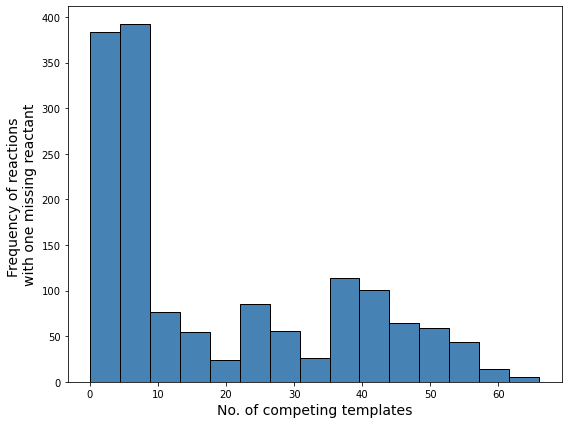

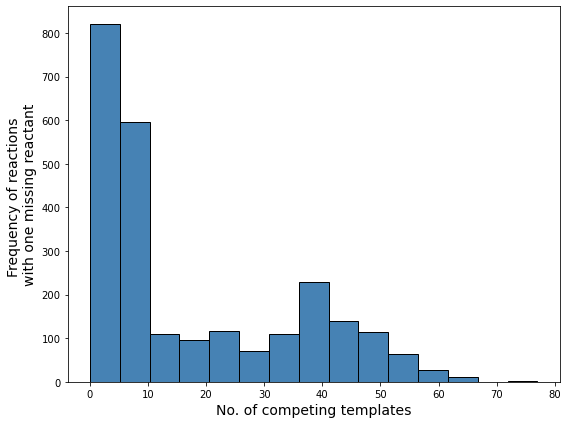

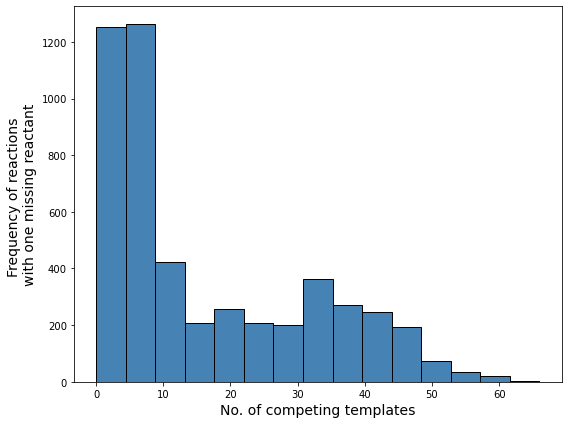

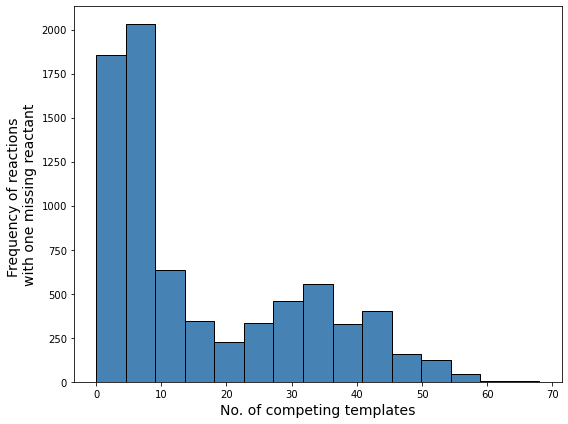

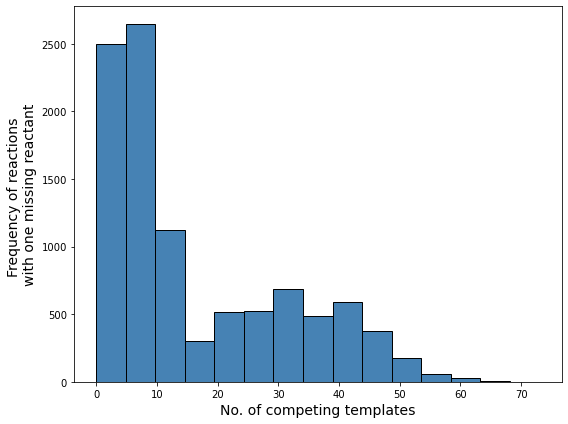

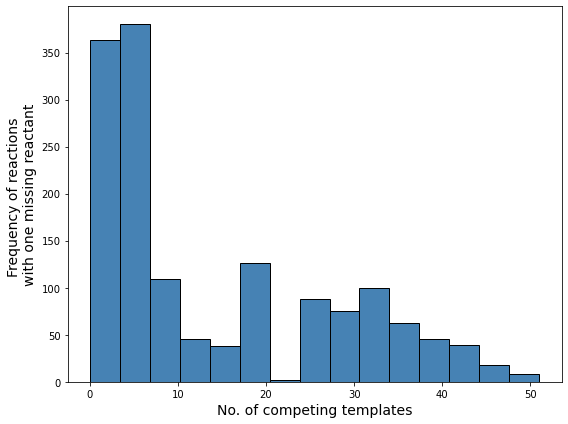

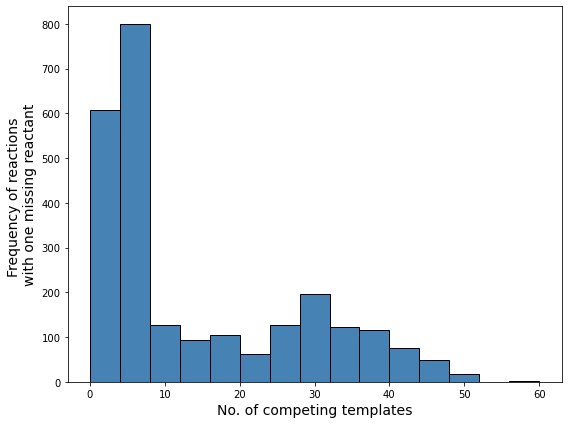

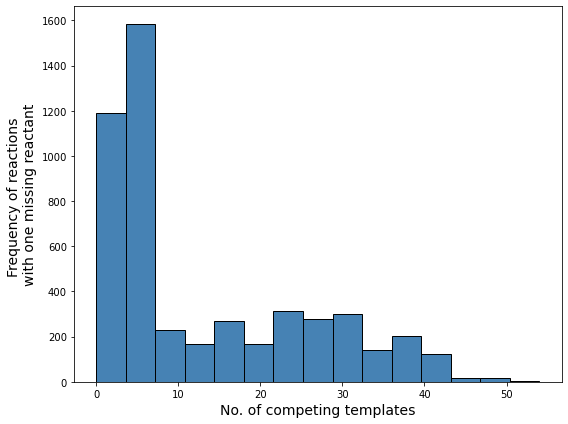

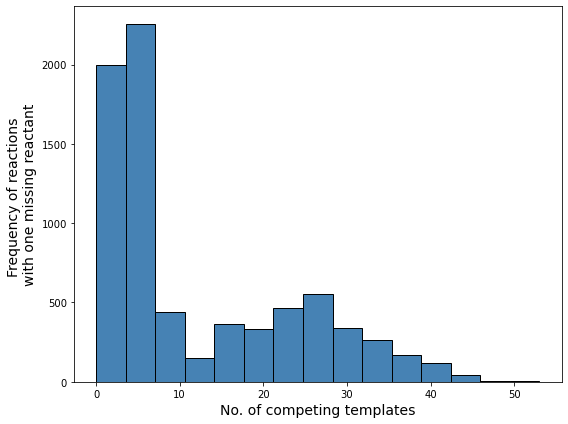

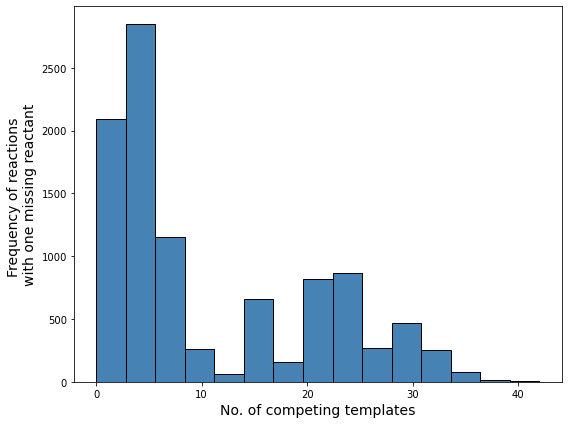

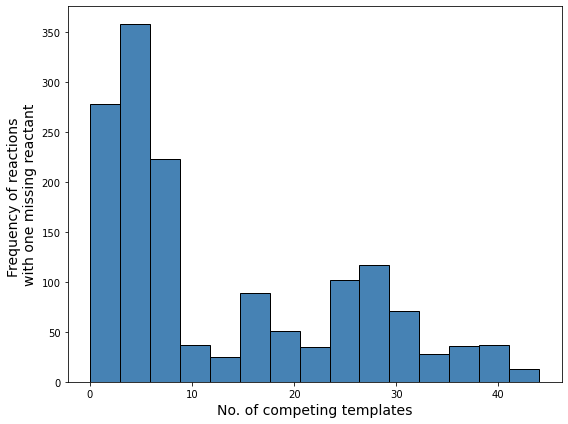

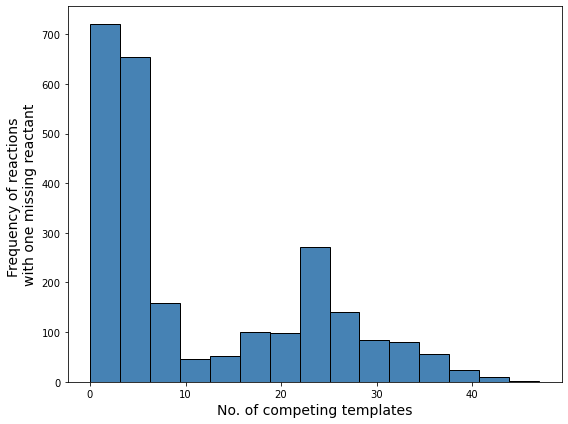

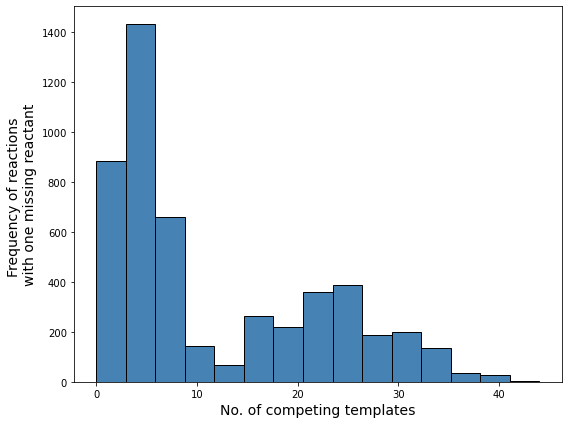

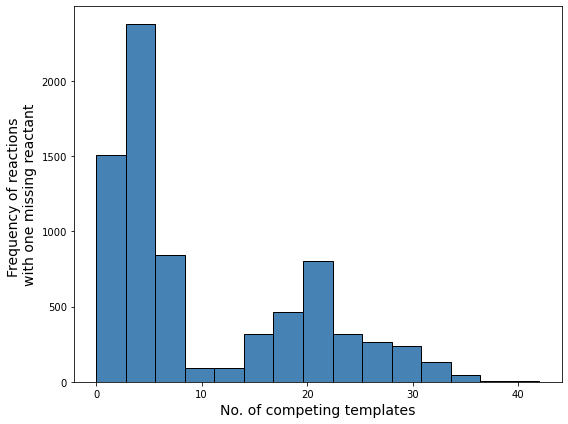

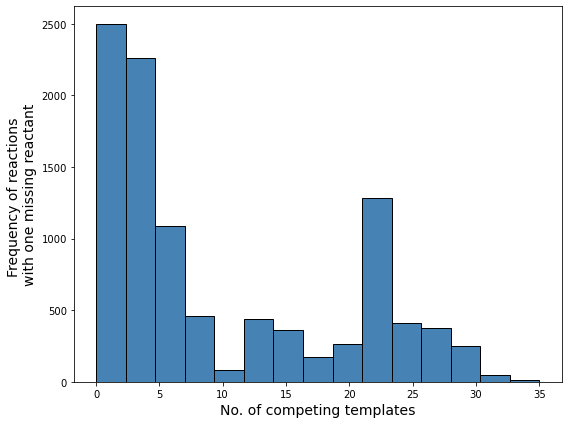

In [85]:
for threshold in thresholds:
    for fraction in fractions:

        trace_path = f"../data_USPTO_50k_noise/USPTO_50k_{fraction}perc_noise/USPTO_50k_{fraction}perc_noise_trace.txt"
        trace_dict = error_type2id_dict(trace_path)
        noise_data_path = f"../data_USPTO_50k_noise/USPTO_50k_{fraction}perc_noise/USPTO_50k_{fraction}perc_noise.txt"
        template_path = f"../data_USPTO_50k_noise/USPTO_50k_{fraction}perc_noise/threshold_{threshold}/all_templates_used.csv"
        all_templates = list(pd.read_csv(template_path)["template"])

        def count_competing_template(noise_rxn_smiles):
            reactant, product = noise_rxn_smiles.split(">>")
            reactant = canon_remap(reactant).split(".")
            num_competing_templates = 0
            for template in all_templates:
                outcomes = rdchiralRunText_modified(template, product)
                outcomes = [canon_remap(outcome) for outcome in outcomes]
                outcomes = [x.split(".") for x in outcomes if x is not None]
                for outcome in outcomes:
                    if check_contains(outcome, reactant):
                        num_competing_templates += 1
                        break
            return num_competing_templates


        with open(noise_data_path, "r") as f:
            noise_data = f.readlines()
        noise_rxn_smiles_list = []
        for line in noise_data:
            rxn_smiles, id_ = line.strip().split("\t")
            if trace_dict[id_] == "remove_one_reactant":
                noise_rxn_smiles_list.append(rxn_smiles)

        with multiprocessing.Pool(processes=48) as pool:
            count_list = pool.map(count_competing_template, noise_rxn_smiles_list)

        print(f"Error fraction {fraction}%, with threshold {threshold}:")
        print("Average number of competing templates: {:.2f}".format(np.average(count_list)))

        # Histogram
        fig = plt.figure(figsize = (8,6))
        fig.subplots_adjust(top=0.85, wspace=0.3)

        ax = fig.add_subplot(1, 1, 1)
        ax.set_xlabel("No. of competing templates", fontsize=14)
        ax.set_ylabel("Frequency of reactions \nwith one missing reactant", fontsize=14) 

        freq, bins, patches = ax.hist(count_list, color='steelblue', bins=15,
                                            edgecolor='black', linewidth=1)
        plt.tight_layout()
        plt.savefig(f"../docs/competing_templates/ct_{fraction}perc_threshold_{threshold}.svg", format="svg")



13.032666666666668


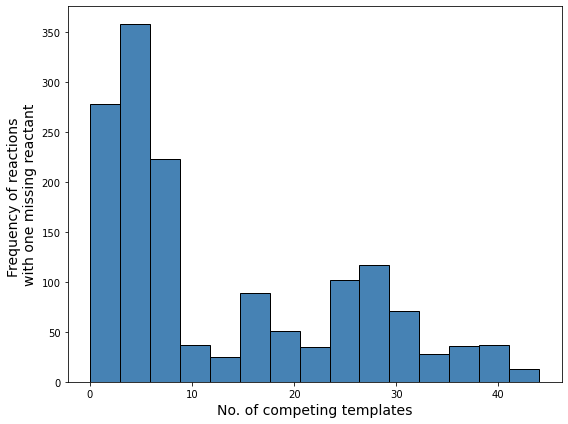

In [83]:
# Histogram
fig = plt.figure(figsize = (8,6))
fig.subplots_adjust(top=0.85, wspace=0.3)

ax = fig.add_subplot(1, 1, 1)
ax.set_xlabel("No. of competing templates", fontsize=14)
ax.set_ylabel("Frequency of reactions \nwith one missing reactant", fontsize=14) 

freq, bins, patches = ax.hist(count_list, color='steelblue', bins=15,
                                    edgecolor='black', linewidth=1)
plt.tight_layout()
plt.savefig(f"../docs/competing_templates/ct_{fraction}perc_threshold_{threshold}.svg", format="svg")

In [72]:
noise_rxn_smiles = "[CH3:8][CH:9]([CH3:10])[SH:11]>>[c:1]1([S:11][CH:9]([CH3:8])[CH3:10])[c:2]([F:3])[cH:4][cH:5][cH:6][n:7]1"
outcomes = rdchiralRunText_modified("[#16:2]-[#6:1]>>Cl-[#6:1].[#16:2]", "[c:1]1([S:11][CH:9]([CH3:8])[CH3:10])[c:2]([F:3])[cH:4][cH:5][cH:6][n:7]1")
outcomes = [canon_remap(outcome) for outcome in outcomes]
outcomes

['CC(C)S.Fc1cccnc1Cl', 'CC(C)Cl.Fc1cccnc1S']

In [9]:
list(golden_id2cgr_dict.keys())

['US05849732_0',
 'US20120114765A1_1',
 'US08003648B2_2',
 'US09045475B2_3',
 'US08188098B2_4',
 'US20140275084A1_5',
 'US20110224204A1_6',
 'US20130005716A1_7',
 'US20130172384A1_8',
 'US20050277619A1_9',
 'US20110263607A1_10',
 'US06372735B1_11',
 'US20100003305A1_12',
 'US07820673B2_13',
 'US20050148627A1_14',
 'US20070225349A1_15',
 'US05834461_16',
 'US20150057271A1_17',
 'US05612288_18',
 'US20120202797A1_19',
 'US05866589_20',
 'US20110152240A1_21',
 'US20060217346A1_22',
 'US09133104B2_23',
 'US20040224976A1_24',
 'US05872117_25',
 'US20090286778A1_26',
 'US05556977_27',
 'US20030232832A1_28',
 'US08258134B2_29',
 'US20110092461A1_30',
 'US04298535_31',
 'US06051731_32',
 'US20120142685A1_33',
 'US08664216B2_34',
 'US04564609_35',
 'US20120016029A1_36',
 'US07964613B2_37',
 'US20090081165A1_38',
 'US08404673B2_39',
 'US06888000B2_40',
 'US07285558B2_41',
 'US04006232_42',
 'US04927956_43',
 'US20100009970A1_44',
 'US06153768_45',
 'US20090105305A1_46',
 'US20150018332A1_47',
 '

In [10]:
for reaction_id in prcessed_id2cgr_dict.keys():
    if prcessed_id2cgr_dict[reaction_id] != golden_id2cgr_dict[reaction_id]:
        print(reaction_id, prcessed_id2cgr_dict[reaction_id], golden_id2cgr_dict[reaction_id])

US08003648B2_2
 CCN(CC)[.>-]C(c1ccc(cc1)-c2nc(c(COc3ccc(cc3)C(c4nocc4)CC(N5C(OCC5Cc6ccccc6)=O)=O)s2)C)[->.]Cl c1ccccc1CC2N(C(OC2)=O)C(=O)CC(c3nocc3)c4ccc(cc4)OCc5c(C)nc(s5)-c6ccc(cc6)C([.>-]N(CC)CC)[=>.]O
US05612288_18
 CC(C)S[.>-]c1(c(cccn1)F)[->.]Br CC(C)S[.>-]c1([->.]F)c(cccn1)F
US09133104B2_23
 [O-][N+](=O)c1cc(C([.>-]N)[->.]Cl)ccc1 [O-][N+](=O)c1cc(C([.>-]N)[->.]Br)ccc1
US20110092461A1_30
 c1(ncccc1)-c2c(ccc(c2)N[.>-]C([->.]Cl)(=O)c3cnc(cc3)-n4ncnc4)Cl c1(ncccc1)-c2c(ccc(N[.>-]C(c3cnc(cc3)-n4ncnc4)([->.]O)=O)c2)Cl
US08404673B2_39
 FC(F)(F)c1cc(c(C(NC2C(N[.>-]C3(CCN(CC3)C(C)=O)[->.]Cl)CCCC2)=O)c(C(F)(F)F)c1)OC FC(F)(F)c1cc(OC)c(C(=O)NC2CCCCC2N[.>-]C3(CCN(CC3)C(C)=O)[=>.]O)c(C(F)(F)F)c1
US20150018332A1_47
 FC(F)(F)c1cc(cc(C(F)(F)F)c1)([->.]B(O)O)[.>-]c2(ncnc2)[->.]Br FC(F)(F)c1cc(cc(C(F)(F)F)c1)([.>-]c2([->.]I)cncn2)[->.]B(O)O
US20140113898A1_75
 FC(F)(F)c1cc(C(=O)OC)n([.>-]C([->.]Cl)CBr)n1 FC(F)(F)c1cc(n([.>-]C([->.]Br)CBr)n1)C(=O)OC
US05011992_78
 C(C)N(CC)CCNC(c1cc(Cl)c(cc1O[.>-]

In [4]:
# In the noise fraction = 20*3% dataset, threshold = 5 processed results
# USPTO patent number: US05612288_18
golden_rxn_smiles = "[CH3:8][CH:9]([CH3:10])[SH:11].[F:12][c:1]1[c:2]([F:3])[cH:4][cH:5][cH:6][n:7]1>>[c:1]1([S:11][CH:9]([CH3:8])[CH3:10])[c:2]([F:3])[cH:4][cH:5][cH:6][n:7]1"
noise_rxn_smiles = "[CH3:8][CH:9]([CH3:10])[SH:11]>>[c:1]1([S:11][CH:9]([CH3:8])[CH3:10])[c:2]([F:3])[cH:4][cH:5][cH:6][n:7]1"
false_processed_rxn_smiles = "[SH:2][CH:3]([CH3:4])[CH3:5].[c:1]1([Br:12])[c:6]([F:7])[cH:8][cH:9][cH:10][n:11]1>>[c:1]1([S:2][CH:3]([CH3:4])[CH3:5])[c:6]([F:7])[cH:8][cH:9][cH:10][n:11]1"
false_template = "[#16:2]-[#6:1]>>Br-[#6:1].[#16:2]"
true_template = "[#16:2]-[#6:1]>>F-[#6:1].[#16:2]"

In [5]:
golden_cgr = cgr_representation(golden_rxn_smiles)
print(golden_cgr)
false_processed_cgr = cgr_representation(false_processed_rxn_smiles)
print(false_processed_cgr)

CC(C)S[.>-]c1([->.]F)c(cccn1)F
CC(C)S[.>-]c1(c(cccn1)F)[->.]Br


In [16]:
import networkx as nx
from rdkit import Chem

def get_atoms_attributes(rdkit_molecule):
    attributes = []
    for a in rdkit_molecule.GetAtoms():
        attributes.append((a.GetAtomMapNum(), {'Symbol':a.GetSymbol(), 'Charge':a.GetFormalCharge()}))
    return attributes

def get_bonds_attributes(rdkit_molecule):
    attributes = []
    for b in rdkit_molecule.GetBonds():
        start = b.GetBeginAtom().GetAtomMapNum()
        end = b.GetEndAtom().GetAtomMapNum()
        b_type = b.GetBondTypeAsDouble()
        attributes.append((start, end, b_type))
    return attributes

def topology_from_rdkit(rdkit_molecule):
    topology = nx.Graph()
    topology.add_nodes_from(get_atoms_attributes(rdkit_molecule))
    topology.add_weighted_edges_from(get_bonds_attributes(rdkit_molecule))
    return topology

def difference_only_halogen(smiles_1, smiles_2):
    G1 = topology_from_rdkit(Chem.MolFromSmiles(smiles_1))
    G2 = topology_from_rdkit(Chem.MolFromSmiles(smiles_2))
    ismags = nx.isomorphism.ISMAGS(G1,G2, node_match=lambda n1,n2:n1['Symbol']==n2['Symbol'],
                                    edge_match=lambda e1,e2:e1['weight']==e2['weight'])
    largest_common_subgraph_mapping = list(ismags.largest_common_subgraph())[0]
    different_nodes_G1 = set(G1.nodes) - set(largest_common_subgraph_mapping.keys())
    different_nodes_G2 = set(G2.nodes) - set(largest_common_subgraph_mapping.values())
    for map_num in different_nodes_G1:
        if G1.nodes[map_num]["Symbol"] not in ["F", "Cl", "Br", "I"]:
            return False
    for map_num in different_nodes_G2:
        if G2.nodes[map_num]["Symbol"] not in ["F", "Cl", "Br", "I"]:
            return False
    return True

print(difference_only_halogen("[CH3:8][CH:9]([CH3:10])[SH:11].[F:12][c:1]1[c:2]([F:3])[cH:4][cH:5][cH:6][n:7]1", 
                              "[SH:2][CH:3]([CH3:4])[CH3:5].[c:1]1([Br:12])[c:6]([F:7])[cH:8][cH:9][cH:10][n:11]1"))
# # 创建两个不同的图
# G1 = topology_from_rdkit(Chem.MolFromSmiles("[CH3:8][CH:9]([CH3:10])[SH:11].[F:12][c:1]1[c:2]([F:3])[cH:4][cH:5][cH:6][n:7]1")) # [CH3:8][CH:9]([CH3:10])[SH:11].[F:12][c:1]1[c:2]([F:3])[cH:4][cH:5][cH:6][n:7]1
# G2 = topology_from_rdkit(Chem.MolFromSmiles("[SH:2][CH:3]([CH3:4])[CH3:5].[c:1]1([Br:12])[c:6]([F:7])[cH:8][cH:9][cH:10][n:11]1"))


# ismags  = nx.isomorphism.ISMAGS(G1,G2, node_match=lambda n1,n2:n1['Symbol']==n2['Symbol'],
#                                     edge_match=lambda e1,e2:e1['weight']==e2['weight'])

# largest_common_subgraph_mapping = list(ismags.largest_common_subgraph())[0]
# # print(max_subgraph)
# # # 获取最大同构子图的映射

# if largest_common_subgraph_mapping:
#     print("找到最大同构子图的映射:", largest_common_subgraph_mapping)
#     # 找出在最大同构子图中不存在的节点
#     different_nodes_G1 = set(G1.nodes) - set(largest_common_subgraph_mapping.keys())
#     different_nodes_G2 = set(G2.nodes) - set(largest_common_subgraph_mapping.values())
#     print("在G1中不同的节点:", different_nodes_G1)
#     print("在G2中不同的节点:", different_nodes_G2)
# else:
#     print("未找到最大同构子图。")

True


In [9]:
ismags  = nx.isomorphism.ISMAGS(G1,G2, node_match=lambda n1,n2:n1['Symbol']==n2['Symbol'],
                                    edge_match=lambda e1,e2:e1['weight']==e2['weight'])

largest_common_subgraph = list(ismags.largest_common_subgraph())
print(largest_common_subgraph)

[{1: 1, 11: 2, 9: 3, 8: 4, 10: 5, 7: 11, 2: 6, 4: 8, 5: 9, 6: 10, 3: 7}, {1: 1, 11: 2, 9: 3, 10: 4, 8: 5, 7: 11, 2: 6, 4: 8, 5: 9, 6: 10, 3: 7}]


In [12]:
G1.nodes[12]

{'Symbol': 'F', 'Charge': 0}

In [24]:
import sys
sys.path.append("../")
from autotemplate.extract_utils import extract_from_rxn_smiles

print(extract_from_rxn_smiles(golden_rxn_smiles))
print(extract_from_rxn_smiles(false_processed_rxn_smiles))

[#16:1]-[#6:2]>>[#16:1].[#6:2]-[#9:3]
[#16:1]-[#6:3]>>[#16:1].[#35:2]-[#6:3]


In [18]:
for a in GM.candidate_pairs_iter():
    print(a)

(2, 2)
(3, 2)
(4, 2)
(5, 2)
(1, 2)
(12, 2)
(6, 2)
(7, 2)
(8, 2)
(9, 2)
(10, 2)
(11, 2)


In [23]:
import sys
sys.path.append("../")
from autotemplate.run_utils import rdchiralRunText_modified
from autotemplate.extract_utils import extract_from_rxn_smiles, canon_remap

rxn_smiles = "CO[C:1](=[O:2])[CH2:3][S:4][CH3:5].[CH3:6][O:7][c:8]1[cH:9][cH:10][c:11]([NH2:12])[c:13]([CH3:14])[c:15]1[CH3:16]>>[C:1]1(=[O:2])[CH:3]([S:4][CH3:5])[c:10]2[cH:9][c:8]([O:7][CH3:6])[c:15]([CH3:16])[c:13]([CH3:14])[c:11]2[NH:12]1"
product = "[C:1]1(=[O:2])[CH:3]([S:4][CH3:5])[c:10]2[cH:9][c:8]([O:7][CH3:6])[c:15]([CH3:16])[c:13]([CH3:14])[c:11]2[NH:12]1"
t = extract_from_rxn_smiles(rxn_smiles)
print(t)
# t = "[C:1]1-[C:2]-[C:3]-[C:4]-[C:5]-[N:6]-1>>[c:1]1=[c:2]-[c:3]=[c:4]-[c:5]=[n:6]-1"
# t = "[#6:1]1-[#6:2]-[#6:3]-[#6:4]-[#6:5]-[#7:6]-1>>[#6:1]1=[#6:2]-[#6:3]=[#6:4]-[#6:5]=[#7:6]-1"
rdchiralRunText_modified(t, product)


[#6:9]1=[#6:4]2-[#7:3]-[#6:1]-[#6:2]-[#6:5]-2=[#6:6]-[#6:7]=[#6:8]-1>>C-O-[#6:1]-[#6:2].[#7:3]-[#6:4]1=[#6:5]-[#6:6]=[#6:7]-[#6:8]=[#6:9]-1


['[C:1](=[O:2])([CH2:3][S:4][CH3:5])[O:18][CH3:17].[cH:6]1[cH:7][c:8]([O:9][CH3:10])[c:11]([CH3:12])[c:13]([CH3:14])[c:15]1[NH2:16]']

In [7]:
canon_remap('[CH3:1][C:2]([OH:3])([CH2:4][OH:5])[c:6]1[cH:7][cH:8][n:9][cH:10][cH:11]1')

'CC(O)(CO)c1ccncc1'

In [1]:
import sys
sys.path.append("../")
from autotemplate.run_utils import rdchiralRunText_modified
from autotemplate.extract_utils import extract_from_rxn_smiles, canon_remap

rxn_smiles = "O=C(O[OH:1])c1cccc(Cl)c1.[CH3:2][c:3]1[n:4][c:5]([Br:6])[cH:7][cH:8][c:9]1[F:10]>>[O-:1][n+:4]1[c:3]([CH3:2])[c:9]([F:10])[cH:8][cH:7][c:5]1[Br:6]"
product = "[O-:1][n+:4]1[c:3]([CH3:2])[c:9]([F:10])[cH:8][cH:7][c:5]1[Br:6]"
t = extract_from_rxn_smiles(rxn_smiles)
print(t)

rdchiralRunText_modified(t, product)

[#7;+1:2]-[#8;-1:1]>>Cl-C1=C-C(-C(=O)-O-[#8;+0:1])=C-C=C-1.[#7;+0:2]


['[OH:1][O:17][C:15]([c:14]1[cH:13][c:12]([Cl:11])[cH:20][cH:19][cH:18]1)=[O:16].[n:2]1[c:3]([CH3:4])[c:5]([F:6])[cH:7][cH:8][c:9]1[Br:10]']

In [31]:
import re

def map2label(labels):
    map2label = dict ()
    for label in labels:
        mapnum = re.search(r'\[(.*?)\:(.*?)\]', label).group(2)
        charge_list = re.findall(r'[+-]\d+', label)
        if charge_list:
            charge = charge_list[0]
        else:
            charge = "0"
        map2label.update({mapnum: (label, charge)})
    return map2label

def neutralize_reactant_fragments(reactant_fragments, product_fragments):
    reactant_fragments = "(Cl-C1=C-C(-C(=O)-O-[#8:1])=C-C=C-1).([#7:4])"
    product_fragments = "([#7;+1:4]-[#8;-1:1])"
    r_labels = re.findall(r'\[[^\[\]]+\]', reactant_fragments)
    p_labels = re.findall(r'\[[^\[\]]+\]', product_fragments)
    if (not p_labels) or (not r_labels):
        return reactant_fragments, product_fragments

    new_reactant_fragments = reactant_fragments

    r_map2label = map2label(r_labels)
    p_map2label = map2label(p_labels)

    for mapnum, p_values in p_map2label.items():
        p_label, p_charge = p_values
        r_values = r_map2label.get(mapnum)
        if r_values == None:
            continue
        else:
            r_label, r_charge = r_values
            if (p_charge != "0") and (r_charge == "0"):
                new_r_label = r_label.replace(":", ";+0:")
                new_reactant_fragments = new_reactant_fragments.replace(r_label, new_r_label)

    return new_reactant_fragments, product_fragments


In [16]:
match = re.search(r'\[(.*?)\:(.*?)\]', '[#8;+4;D3;H1:142]')
match.group(2)

'142'

In [9]:
import re
from rdkit import Chem

# def SmartsMolWithFormalCharge(smarts):
#     """
#     [O+]-[#6:3]=[#7;+1:4]=[#7;-2:5]
#     """
smarts = "[O+]-[#6:3]=[#7;+1:4]=[#7;-2:5]-[#6;+0:6]"
mol = Chem.MolFromSmarts(smarts)
# smarts_convert = ']'.join([x for x in smarts.split('[') if (':' in x) and (x != ':')])
# smarts_convert = [x for x in smarts_convert.split(']') if (':' in x) and (x != ':')]
smarts_convert = re.findall('\[([^]]*)\]', smarts)
smarts_convert = [x for x in smarts_convert if ':' in x]
formalcharge_dict = dict()
for symbol in smarts_convert:
    charge = re.search('([-+]+[0-9]?)', symbol)
    if charge:
        mapnum = int(re.search('\:([0-9]+)', symbol).group()[1:])
        formalcharge_dict.update({mapnum: int(charge.group())})

for atom in mol.GetAtoms():
    mapnum = int(atom.GetAtomMapNum())
    if mapnum and (mapnum in formalcharge_dict.keys()):
        atom.SetFormalCharge(formalcharge_dict[mapnum])

    # return mol

In [6]:
import sys
sys.path.append("../")
from autotemplate.run_utils import rdchiralRunText_modified
from autotemplate.extract_utils import extract_from_rxn_smiles, canon_remap

rxn_smiles = "CO[C:1](=[O:2])[CH2:3][S:4][CH3:5].[NH2:6][c:7]1[cH:8][cH:9][c:10]([C:11]([F:12])([F:13])[F:14])[cH:15][cH:16]1>>[C:1]1(=[O:2])[CH:3]([S:4][CH3:5])[c:8]2[c:7]([cH:16][cH:15][c:10]([C:11]([F:12])([F:13])[F:14])[cH:9]2)[NH:6]1"
product = "[C:1]1(=[O:2])[CH:3]([S:4][CH3:5])[c:8]2[c:7]([cH:16][cH:15][c:10]([C:11]([F:12])([F:13])[F:14])[cH:9]2)[NH:6]1"
t = extract_from_rxn_smiles(rxn_smiles)
print(t)

rdchiralRunText_modified(t, product)



[#6:3]-[#6:2]-[#6:1]-[#7:4]>>C-O-[#6:1]-[#6:2].[#6:3].[#7:4]


['[C:1](=[O:2])([CH2:3][S:4][CH3:5])[O:18][CH3:17].[cH:6]1[c:7]([NH2:16])[cH:8][cH:9][c:10]([C:11]([F:12])([F:13])[F:14])[cH:15]1']

In [3]:
import re

# 定義你的字串
s = "(Cl-C1=C-C(-C(=O)-O-[#8:1])=C-C=C-1).([#7:4]-[Sr])"

# 使用 re.findall() 函式來找出所有符合條件的字串
result = re.findall(r'\[[^\[\]:]*:[^\[\]]*\]', s)

print(result)

['[#8:1]', '[#7:4s]']
